Text(0.5, 1.0, 'Constructed MA(1) series')

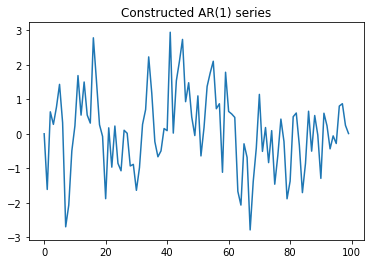

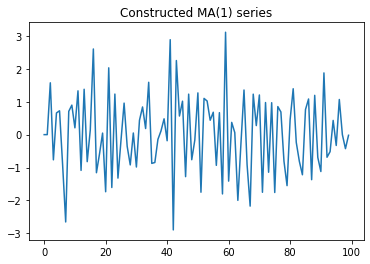

In [10]:
#from lppy import locproj
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt

#of generated observations
T = 100

#Create a shock vector for the time series
sigma = 1
s = np.random.normal(0, sigma, T)

#Simulate an AR1 process
alpha = .5 #persistence term
theta = .5 #persistence term
AR1 = np.empty(T)
MA1 = np.empty(T)
AR1[0] = 0 
MA1[0] = 0 
MA1[1] = 0 
for i in range(2,T):
    AR1[i] = alpha*AR1[i-1] + s[i]
    MA1[i] = s[i] - theta*s[i-1]
plt.plot(AR1)
plt.title("Constructed AR(1) series")

plt.figure()
plt.plot(MA1)
plt.title("Constructed MA(1) series")

#Create test data 



In [8]:
#This defines a simple local projection function in python
#Dependencies
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

"""
DEFINE: locproj() => a function to estimate local projects as in Jorda 2005
-----------------------INPUTS -------------------------------
X: matrix containig the shock of interest +  controls
Y: response variable of interest (must be a single vector)
innov_idx: column index of the shock vector in X (indexes start at zero)
horizon: the # of periods you want to know the response for
sig_level: add as an # in (00,100): ex. 90 => function will output 90% confidence interval

------------------------OUTPUTS -----------------------------
irf: the dataframe of resulting response, confidence interval, and horizon
info_store: DF containing series info (units, titles, notes, etc.)
"""

def locproj(X,Y,innov_idx,horizon,sig_level):
    
    #Create an empty array to store results
    irf = np.empty([horizon+1,4])
 
    if Y.ndim > 1:
        raise Exception("INPUT ERROR: Y must be a single column vector")

    if not 0 < sig_level < 100:
        raise Exception("INPUT ERROR: significance level not in range 1 - 100")
    
    #loop from 0 to h periods ahead
    for h in range(0,horizon+1):
        X = sm.add_constant(X)
        #At each point, shift the Y matrix forward, while trimming X to keep them the same length
        X_reg = X[0:len(X)-h,:]
        Y_reg = Y[h:]
        model = sm.OLS(Y_reg, X_reg).fit()
        
        #Return the level for the confidence bands 
        sig_level_se = norm.ppf(1-((100-sig_level)/200))
        #store results in row h
        irf[h,0] = h
        irf[h,1] = model.params[innov_idx+1]
        
        #Create confidence interval bands
        irf[h,2] = irf[h,1]+(model.HC0_se[innov_idx+1]*(-1*sig_level_se))
        irf[h,3] = irf[h,1]+(model.HC0_se[innov_idx+1]*sig_level_se)
    
    #Collect resul matrix into a dataframe
    irf_df = pd.DataFrame(irf, columns = ['horizon','resp','se_low','se_high'])
    return irf_df



             

Text(0.5, 1.0, 'Local projection vs Actual')

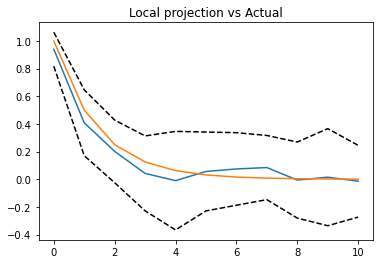

In [19]:
irf = locproj(s,AR1,0,10,99)
irf.head
plt.plot(irf.resp)
plt.plot(irf.se_low,'k--')
plt.plot(irf.se_high,'k--')
resp = np.power(alpha, irf.horizon)
plt.plot(resp)   
plt.title("Local projection vs Actual")  

Text(0.5, 1.0, 'Local projection vs Actual')

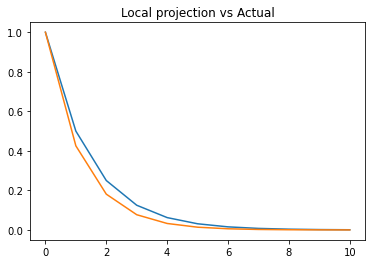

In [20]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

AR1_lag1 = np.roll(AR1, -1)
model = sm.OLS(AR1[1:100],AR1_lag1[1:100])
results = model.fit()
results.summary()
beta = results.params[0]
plt.figure()

resp = np.power(alpha, irf.horizon)
estimate = np.power(beta, irf.horizon)
plt.plot(resp,label="actual") 
plt.plot(estimate,label="estimate")
plt.title("Local projection vs Actual")  